In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib import cm, colors
sns.set_theme()

import os
import init_simple_mdp as imdp
import init_load_board as ib

## 1. Heatmaps

In [2]:
epsilon_list = [1,2,3,4,5,6,7,8,9]
epsilon_list_extremes = [25,50,100]
epsilon_list_presentation = [1,9]

In [3]:
df = pd.read_csv('player10_results.csv')
df = df[['epsilon','tokens','score','remaining_throws','score_gained','optimal_value','optimal_policy']]

# Map to policy action names 
a_map = {i:imdp.a_list[i] for i in range(len(imdp.a_list))}
df['optimal_policy_name'] = df['optimal_policy'].map(a_map)

In [4]:
df0 = df.loc[df.tokens==0].copy()
df0['ppd'] = df0.score / df0.optimal_value

# Create dataframes for values at 501 for each token value 
epsilon_dfs = []

for e in range(len(epsilon_list)):
    epsilon = epsilon_list[e]
    temp = df0.loc[df0.epsilon==epsilon].set_index('score')['optimal_policy_name'].copy()
    epsilon_dfs.append(temp)


epsilon_dfs_expanded = []

for e in range(len(epsilon_list)):

    epsilon = epsilon_list[e]

    temp_list = []
    for action in epsilon_dfs[e]: 
        try: 
            temp_list.append([action,imdp.actions[action]['coords'][0],imdp.actions[action]['coords'][1]])
        except: 
            continue

    temp = pd.DataFrame(temp_list, columns = ['a','x','y'])
    
    epsilon_dfs_expanded.append(temp)



In [5]:
def createKde(data, x, y, title="", ax=None, cmap='Blues', levels=10, alpha=1):
    if ax == None:
        ax = plt.gca()
    sns.kdeplot(data=data, x=x, y=y, cmap=cmap, fill=True, levels=levels, ax=ax, alpha=alpha)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ib.plot_basic_board(axes=ax)
    ax.title.set_text(title)

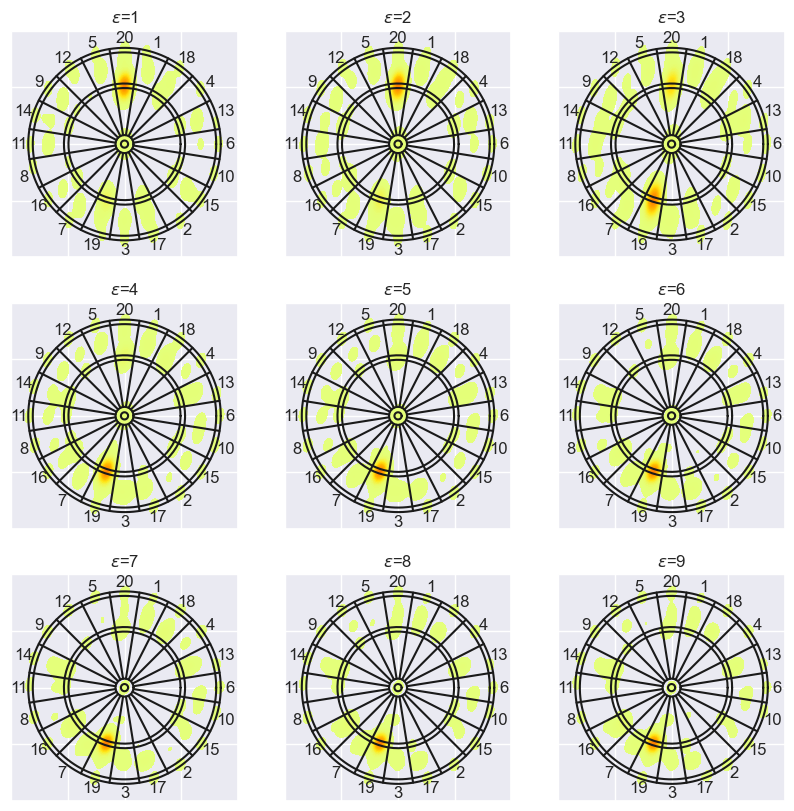

In [6]:

cmap = 'Wistia'
alpha = 1
levels = 50

fig, ax = plt.subplots(3, 3,figsize=(10,10))

createKde(data=epsilon_dfs_expanded[0], x='x', y='y', title="$\epsilon$=1", ax=ax[0,0], cmap=cmap, levels=levels, alpha=alpha)
createKde(data=epsilon_dfs_expanded[1], x='x', y='y', title="$\epsilon$=2", ax=ax[0,1], cmap=cmap, levels=levels, alpha=alpha)
createKde(data=epsilon_dfs_expanded[2], x='x', y='y', title="$\epsilon$=3", ax=ax[0,2], cmap=cmap, levels=levels, alpha=alpha)
createKde(data=epsilon_dfs_expanded[3], x='x', y='y', title="$\epsilon$=4", ax=ax[1,0], cmap=cmap, levels=levels, alpha=alpha)
createKde(data=epsilon_dfs_expanded[4], x='x', y='y', title="$\epsilon$=5", ax=ax[1,1], cmap=cmap, levels=levels, alpha=alpha)
createKde(data=epsilon_dfs_expanded[5], x='x', y='y', title="$\epsilon$=6", ax=ax[1,2], cmap=cmap, levels=levels, alpha=alpha)
createKde(data=epsilon_dfs_expanded[6], x='x', y='y', title="$\epsilon$=7", ax=ax[2,0], cmap=cmap, levels=levels, alpha=alpha)
createKde(data=epsilon_dfs_expanded[7], x='x', y='y', title="$\epsilon$=8", ax=ax[2,1], cmap=cmap, levels=levels, alpha=alpha)
createKde(data=epsilon_dfs_expanded[8], x='x', y='y', title="$\epsilon$=9", ax=ax[2,2], cmap=cmap, levels=levels, alpha=alpha)



In [8]:
import function_board as fb
import scipy.io as sio
from scipy.stats import multivariate_normal

def get_gaussian(x_val,y_val,error_multiplier,player_index=7):
  
  result_dir = fb.data_parameter_dir + '/grid_full'
  if not os.path.isdir(result_dir):
      os.makedirs(result_dir)
  player_parameter = sio.loadmat('./ALL_Model_Fits.mat')
  
  ## 1mm-width grid of 341*341 aiming locations (a sqaure enclosing the circle dart board)
  [xindex, yindex, xgrid, ygrid, grid_num] = fb.get_1mm_grid()

  xi = np.where(xgrid==x_val)[0][0]
  yi = np.where(xgrid==y_val)[0][0]

  ## select the proper Gaussian distribution according to the area to which the aiming location belongs
  mu = [xgrid[xi], ygrid[yi]]
  score, multiplier = fb.get_score_and_multiplier(mu)
  if (score==60 and multiplier==3): ##triple 20
      covariance_matrix = player_parameter['ModelFit_T20'][0, player_index][2] * error_multiplier
  elif (score==57 and multiplier==3): ##triple 19
      covariance_matrix = player_parameter['ModelFit_T19'][0, player_index][2] * error_multiplier
  elif (score==54 and multiplier==3): ##triple 18
      covariance_matrix = player_parameter['ModelFit_T18'][0, player_index][2] * error_multiplier
  elif (score==51 and multiplier==3): ##triple 17
      covariance_matrix = player_parameter['ModelFit_T17'][0, player_index][2] * error_multiplier
  elif (score==50 and multiplier==2): ##double bull
      covariance_matrix = player_parameter['ModelFit_B50'][0, player_index][2] * error_multiplier
  else:
      covariance_matrix = player_parameter['ModelFit_All_Doubles'][0, player_index][2] * error_multiplier
  
  return mu,covariance_matrix

def plot_gaussian(x_val,y_val,error_multiplier,player_index=7,xlim=(-200,200),ylim=(-200,200),figsize = (8,8),ax=None,title=''):
  
  mu,covariance_matrix = get_gaussian(x_val,y_val,error_multiplier,player_index=player_index)
  rv = multivariate_normal(mu, covariance_matrix)
  
  x, y = np.mgrid[-200:200:1, -200:200:1]
  pos = np.dstack((x, y))
  
  axes = ib.plot_basic_board(xlim=xlim,ylim=ylim,figsize = figsize,axes=ax)
  #axes.plot(x_val, y_val, "or")

  ax.title.set_text(title)
  
  fi = axes.contourf(x, y, rv.pdf(pos), 20, cmap='Greens')


In [12]:
epsilon_dfs_extremes = []

# df0 = df0.loc[df0.]

for e in range(len(epsilon_list_extremes)):
    epsilon = epsilon_list_extremes[e]
    temp = df0.loc[df0.epsilon==epsilon].set_index('score')['optimal_policy_name'].copy()
    epsilon_dfs_extremes.append(temp)


epsilon_dfs_expanded_extremes = []

for e in range(len(epsilon_list_extremes)):

    epsilon = epsilon_list_extremes[e]

    temp_list = []
    for action in epsilon_dfs_extremes[e]: 
        try: 
            temp_list.append([action,imdp.actions[action]['coords'][0],imdp.actions[action]['coords'][1]])
        except: 
            continue

    temp = pd.DataFrame(temp_list, columns = ['a','x','y'])
    
    epsilon_dfs_expanded_extremes.append(temp)

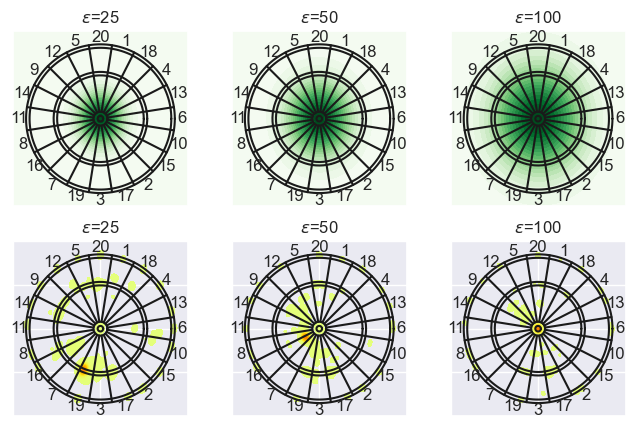

In [13]:
cmap = 'Wistia'
alpha = 1
levels = 30 #50

x_val=0
y_val=0

fig, ax = plt.subplots(2, 3, figsize=(8,5))

for e in range(len(epsilon_list_extremes)):
    col = e % 3
    plot_gaussian(x_val,y_val,epsilon_list_extremes[e],player_index=10,xlim=(-200,200),ylim=(-200,200),ax=ax[0,col],title='$\epsilon$={}'.format(epsilon_list_extremes[e]))
    createKde(data=epsilon_dfs_expanded_extremes[e], x='x', y='y', title="$\epsilon$={}".format(epsilon_list_extremes[e]), ax=ax[1,col], cmap=cmap, levels=levels, alpha=alpha)

    #plt.tight_layout()

In [17]:
epsilon_dfs_presentation = []

# df0 = df0.loc[df0.]

for e in range(len(epsilon_list_presentation)):
    epsilon = epsilon_list_presentation[e]
    temp = df0.loc[df0.epsilon==epsilon].set_index('score')['optimal_policy_name'].copy()
    epsilon_dfs_presentation.append(temp)


epsilon_dfs_expanded_presentation = []

for e in range(len(epsilon_list_presentation)):

    epsilon = epsilon_list_presentation[e]

    temp_list = []
    for action in epsilon_dfs_presentation[e]: 
        try: 
            temp_list.append([action,imdp.actions[action]['coords'][0],imdp.actions[action]['coords'][1]])
        except: 
            continue

    temp = pd.DataFrame(temp_list, columns = ['a','x','y'])
    
    epsilon_dfs_expanded_presentation.append(temp)


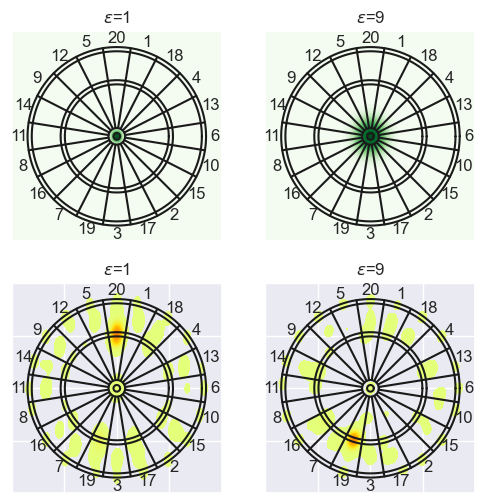

In [19]:
cmap = 'Wistia'
alpha = 1
levels = 30 #50

x_val=0
y_val=0

fig, ax = plt.subplots(2, 2, figsize=(6,6))

for e in range(len(epsilon_list_presentation)):
    col = e % 3
    plot_gaussian(x_val,y_val,epsilon_list_presentation[e],player_index=10,xlim=(-200,200),ylim=(-200,200),ax=ax[0,col],title='$\epsilon$={}'.format(epsilon_list_presentation[e]))
    createKde(data=epsilon_dfs_expanded_presentation[e], x='x', y='y', title="$\epsilon$={}".format(epsilon_list_presentation[e]), ax=ax[1,col], cmap=cmap, levels=levels, alpha=alpha)

    #plt.tight_layout()

## 2. Token Usage

In [53]:
# Add boolean column to indicate whether the policy uses tokens or not 
df['policy_is_token'] = df['optimal_policy'] >= imdp.throw_num
df['score_in_turn'] = df['score'] - df['score_gained']

token_dfs = []

for epsilon in range(7):
    
    temp = df.loc[df.epsilon==epsilon].set_index('epsilon')['optimal_value'].copy()
    token_dfs.append(temp)


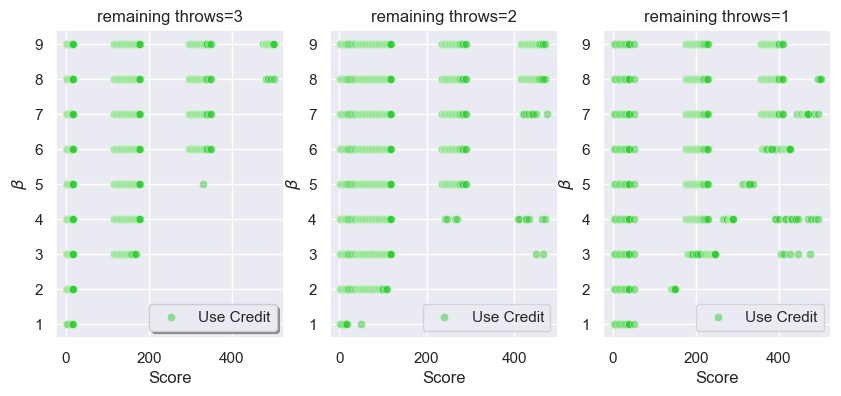

In [59]:
figure, ax = plt.subplots(1, 3,figsize=(10,4))

epsilon = 1
df_temp = df[df.optimal_policy != -1]
df_temp = df_temp[df_temp.score_gained == 0]
df_temp3 = df_temp[df_temp.remaining_throws==3]
df_actions3 = df_temp3[df_temp3.epsilon == epsilon]

#sns.set(rc={'figure.figsize':(6,4)})
fig = sns.scatterplot(data=df_actions3.loc[df_actions3.policy_is_token==True], x="score_in_turn",y="tokens",alpha=0.5,label='Use Credit',color='limegreen',ax=ax[0])
#fig = sns.scatterplot(data=df_actions3.loc[df_actions3.policy_is_token==False], x="score_in_turn",y="tokens",alpha=0.5,label='Throw',color='royalblue',ax=ax[0])

fig = ax[0].set_ylabel(r'$\beta$')
fig = ax[0].set_xlabel(r'Score')
fig = ax[0].set_title(rf'remaining throws={3}')
fig = ax[0].legend(loc='lower right', fancybox=True, shadow=True)

# max_token_list = []
# min_throw_list = []
# for t in range(10):
#     max_token = df_actions3.loc[(df_actions3.tokens==t) & (df_actions3.policy_is_token==True)].score.max()
#     min_throw = df_actions3.loc[(df_actions3.tokens==t) & (df_actions3.policy_is_token==False)].score.min()
#     # ax[0].plot(max_token,t,marker='X',markersize=10,color='green')
#     ax[0].plot(min_throw,t,marker='P',markersize=10,color='blue')


df_temp2 = df_temp[df_temp.remaining_throws==2]
df_actions2 = df_temp2[df_temp2.epsilon == epsilon]

#sns.set(rc={'figure.figsize':(6,4)})
fig = sns.scatterplot(data=df_actions2.loc[df_actions2.policy_is_token==True], x="score_in_turn",y="tokens",alpha=0.5,label='Use Credit',color='limegreen',ax=ax[1])
#fig = sns.scatterplot(data=df_actions2.loc[df_actions2.policy_is_token==False], x="score_in_turn",y="tokens",alpha=0.5,label='Throw',color='royalblue',ax=ax[1])

fig = ax[1].set_ylabel(r'$\beta$')
fig = ax[1].set_xlabel(r'Score')
fig = ax[1].set_title(rf'remaining throws={2}')
#fig = ax[1].legend(loc='lower right', fancybox=True, shadow=True)

# max_token_list = []
# min_throw_list = []
# for t in range(10):
#     max_token = df_actions2.loc[(df_actions2.tokens==t) & (df_actions2.policy_is_token==True)].score.max()
#     min_throw = df_actions2.loc[(df_actions2.tokens==t) & (df_actions2.policy_is_token==False)].score.min()
#     #ax[1].plot(max_token,t,marker='X',markersize=10,color='green')
#     ax[1].plot(min_throw,t,marker='P',markersize=10,color='blue')


df_temp1 = df_temp[df_temp.remaining_throws==1]
df_actions1 = df_temp1[df_temp1.epsilon == epsilon]

#sns.set(rc={'figure.figsize':(6,4)})
fig = sns.scatterplot(data=df_actions1.loc[df_actions1.policy_is_token==True], x="score_in_turn",y="tokens",alpha=0.5,label='Use Credit',color='limegreen',ax=ax[2])
#fig = sns.scatterplot(data=df_actions1.loc[df_actions1.policy_is_token==False], x="score_in_turn",y="tokens",alpha=0.5,label='Throw',color='royalblue',ax=ax[2])

fig = ax[2].set_ylabel(r'$\beta$')
fig = ax[2].set_xlabel(r'Score')
fig = ax[2].set_title(rf'remaining throws={1}')
#fig = ax[2].legend(loc='lower right', fancybox=True, shadow=True)

max_token_list = []
min_throw_list = []
# for t in range(10):
#     max_token = df_actions1.loc[(df_actions1.tokens==t) & (df_actions1.policy_is_token==True)].score.max()
#     min_throw = df_actions1.loc[(df_actions1.tokens==t) & (df_actions1.policy_is_token==False)].score.min()
#     #ax[1].plot(max_token,t,marker='X',markersize=10,color='green')
#     ax[2].plot(min_throw,t,marker='P',markersize=10,color='blue')


#fig = figure.suptitle(r'Optimal Use of Credits in Different States')



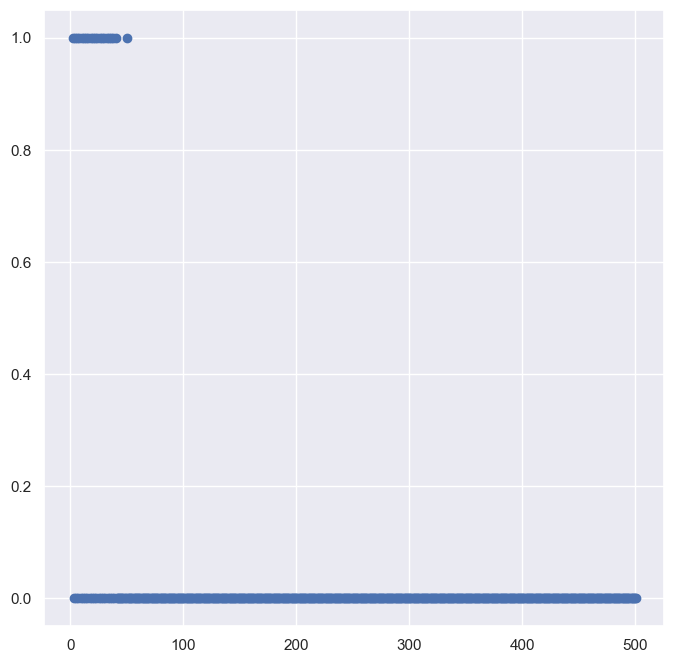

In [154]:
temp = df.groupby(['epsilon','tokens','score_in_turn']).policy_is_token.sum() / df.groupby(['epsilon','tokens','score_in_turn']).policy_is_token.count()
temp = temp.reset_index()
temp = temp.loc[temp.epsilon==5]
temp = temp.loc[temp.tokens==1]
temp
plt.scatter(x=temp['score_in_turn'],y=temp['policy_is_token'])
#temp.plot()


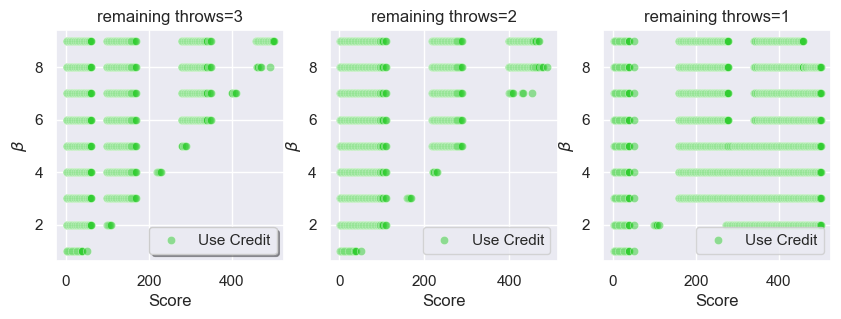

In [88]:
figure, ax = plt.subplots(1, 3,figsize=(10,3))

epsilon = 100
df_temp = df[df.optimal_policy != -1]
df_temp = df[df.score_gained == 0]
df_temp3 = df_temp[df_temp.remaining_throws==3]
df_actions3 = df_temp3[df_temp3.epsilon == epsilon]

#sns.set(rc={'figure.figsize':(6,4)})
fig = sns.scatterplot(data=df_actions3.loc[df_actions3.policy_is_token==True], x="score",y="tokens",alpha=0.5,label='Use Credit',color='limegreen',ax=ax[0])
#fig = sns.scatterplot(data=df_actions3.loc[df_actions3.policy_is_token==False], x="score",y="tokens",alpha=0.5,label='Throw',color='royalblue',ax=ax[0])

fig = ax[0].set_ylabel(r'$\beta$')
fig = ax[0].set_xlabel(r'Score')
fig = ax[0].set_title(rf'remaining throws={3}')
fig = ax[0].legend(loc='lower right', fancybox=True, shadow=True)

# max_token_list = []
# min_throw_list = []
# for t in range(10):
#     max_token = df_actions3.loc[(df_actions3.tokens==t) & (df_actions3.policy_is_token==True)].score.max()
#     min_throw = df_actions3.loc[(df_actions3.tokens==t) & (df_actions3.policy_is_token==False)].score.min()
#     # ax[0].plot(max_token,t,marker='X',markersize=10,color='green')
#     ax[0].plot(min_throw,t,marker='P',markersize=6,color='blue')


df_temp2 = df_temp[df_temp.remaining_throws==2]
df_actions2 = df_temp2[df_temp2.epsilon == epsilon]

#sns.set(rc={'figure.figsize':(6,4)})
fig = sns.scatterplot(data=df_actions2.loc[df_actions2.policy_is_token==True], x="score",y="tokens",alpha=0.5,label='Use Credit',color='limegreen',ax=ax[1])
#fig = sns.scatterplot(data=df_actions2.loc[df_actions2.policy_is_token==False], x="score",y="tokens",alpha=0.5,label='Throw',color='royalblue',ax=ax[1])

fig = ax[1].set_ylabel(r'$\beta$')
fig = ax[1].set_xlabel(r'Score')
fig = ax[1].set_title(rf'remaining throws={2}')
#fig = ax[1].legend(loc='lower right', fancybox=True, shadow=True)

# max_token_list = []
# min_throw_list = []
# for t in range(10):
#     max_token = df_actions2.loc[(df_actions2.tokens==t) & (df_actions2.policy_is_token==True)].score.max()
#     min_throw = df_actions2.loc[(df_actions2.tokens==t) & (df_actions2.policy_is_token==False)].score.min()
#     #ax[1].plot(max_token,t,marker='X',markersize=10,color='green')
#     ax[1].plot(min_throw,t,marker='P',markersize=6,color='blue')


df_temp1 = df_temp[df_temp.remaining_throws==1]
df_actions1 = df_temp1[df_temp1.epsilon == epsilon]

#sns.set(rc={'figure.figsize':(6,4)})
fig = sns.scatterplot(data=df_actions1.loc[df_actions1.policy_is_token==True], x="score",y="tokens",alpha=0.5,label='Use Credit',color='limegreen',ax=ax[2])
#fig = sns.scatterplot(data=df_actions1.loc[df_actions1.policy_is_token==False], x="score",y="tokens",alpha=0.5,label='Throw',color='royalblue',ax=ax[2])

fig = ax[2].set_ylabel(r'$\beta$')
fig = ax[2].set_xlabel(r'Score')
fig = ax[2].set_title(rf'remaining throws={1}')
#fig = ax[2].legend(loc='lower right', fancybox=True, shadow=True)

max_token_list = []
min_throw_list = []
for t in range(10):
    max_token = df_actions1.loc[(df_actions1.tokens==t) & (df_actions1.policy_is_token==True)].score.max()
    min_throw = df_actions1.loc[(df_actions1.tokens==t) & (df_actions1.policy_is_token==False)].score.min()
    #ax[1].plot(max_token,t,marker='X',markersize=10,color='green')
    #ax[2].plot(min_throw,t,marker='P',markersize=6,color='blue')


#fig = figure.suptitle(r'Optimal Use of Credits in Different States')



<AxesSubplot: xlabel='score_in_turn', ylabel='score_gained'>

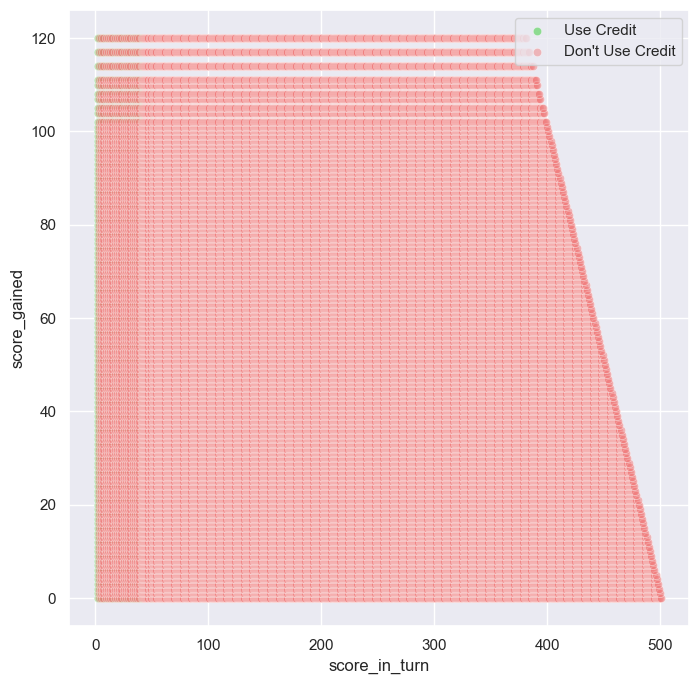

In [125]:
tokens = 1 
epsilon = 1
i = 1 

df_policy_check = df.loc[(df.tokens==tokens) & (df.epsilon==epsilon) & (df.remaining_throws==i)]
df_policy_check[['score_gained','score_in_turn','policy_is_token']]

sns.scatterplot(data=df_policy_check.loc[df_policy_check.policy_is_token==True], x="score_in_turn",y="score_gained",alpha=0.5,label='Use Credit',color='limegreen')
sns.scatterplot(data=df_policy_check.loc[df_policy_check.policy_is_token==False], x="score_in_turn",y="score_gained",alpha=0.5,label='Don\'t Use Credit',color='lightcoral')

#fig = sns.scatterplot(data=df_actions1.loc[df_actions1.policy_is_token==False], x="score",y="tokens",alpha=0.5,label='Throw',color='royalblue',ax=ax[2])

Text(0.5, 0.01, 'Score In Turn ($\\theta - u$)')

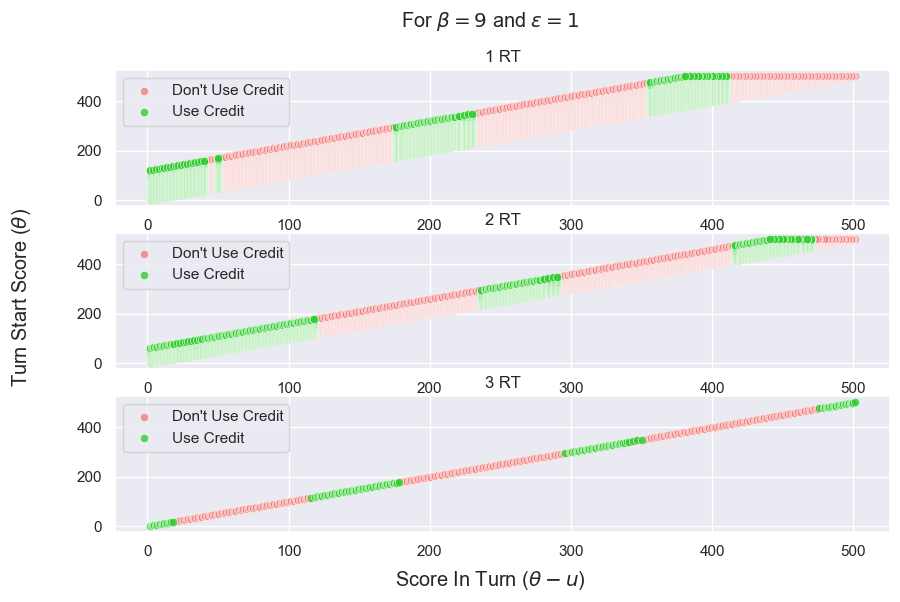

In [162]:
figure, ax = plt.subplots(3, 1,figsize=(10,6))

tokens = 9
epsilon = 1

for i in range (1,4):
    df_policy_check = df.loc[(df.tokens==tokens) & (df.epsilon==epsilon) & (df.remaining_throws==i)]
    df_policy_check[['score','score_in_turn','policy_is_token']]

    fig = sns.scatterplot(data=df_policy_check.loc[df_policy_check.policy_is_token==False], x="score_in_turn",y="score",alpha=0.8,label='Don\'t Use Credit',color='lightcoral',ax=ax[i-1])
    fig = sns.scatterplot(data=df_policy_check.loc[df_policy_check.policy_is_token==True], x="score_in_turn",y="score",alpha=0.8,label='Use Credit',color='limegreen',ax=ax[i-1])
    ax[i-1].set(xlabel="  ")
    ax[i-1].set(ylabel=None)
    ax[i-1].set(title=f"{i} RT")
    
figure.suptitle(rf'For $\beta={tokens}$ and $\epsilon={epsilon}$')
figure.supylabel(r'Turn Start Score ($\theta$)')
figure.supxlabel(r'Score In Turn ($\theta - u$)')
# plt.setp(ax, xlim=(0,100), ylim=(0,200))
# plt.xlim(0,100)
# plt.ylim(0,200)
#fig = sns.scatterplot(data=df_actions1.loc[df_actions1.policy_is_token==False], x="score",y="tokens",alpha=0.5,label='Throw',color='royalblue',ax=ax[2])

/Users/rachael/miniconda3/envs/darts/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/rachael/miniconda3/envs/darts/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


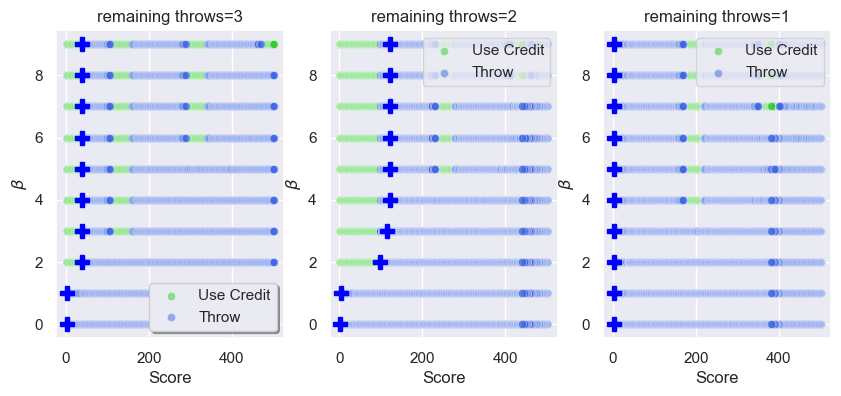

In [55]:
figure, ax = plt.subplots(1, 3,figsize=(10,4))

epsilon = 5
df_temp = df[df.optimal_policy != -1]

df_temp3 = df_temp[df_temp.remaining_throws==3]
df_actions3 = df_temp3[df_temp3.epsilon == epsilon]
#sns.set(rc={'figure.figsize':(6,4)})
fig = sns.scatterplot(data=df_actions3.loc[df_actions3.policy_is_token==True], x="score_in_turn",y="tokens",alpha=0.5,label='Use Credit',color='limegreen',ax=ax[0])
fig = sns.scatterplot(data=df_actions3.loc[df_actions3.policy_is_token==False], x="score_in_turn",y="tokens",alpha=0.5,label='Throw',color='royalblue',ax=ax[0])

fig = ax[0].set_ylabel(r'$\beta$')
fig = ax[0].set_xlabel(r'Score')
fig = ax[0].set_title(rf'remaining throws={3}')
fig = ax[0].legend(loc='lower right', fancybox=True, shadow=True)

max_token_list = []
min_throw_list = []
for t in range(10):
    max_token = df_actions3.loc[(df_actions3.tokens==t) & (df_actions3.policy_is_token==True)].score.max()
    min_throw = df_actions3.loc[(df_actions3.tokens==t) & (df_actions3.policy_is_token==False)].score.min()
    # ax[0].plot(max_token,t,marker='X',markersize=10,color='green')
    ax[0].plot(min_throw,t,marker='P',markersize=10,color='blue')


df_temp2 = df_temp[df_temp.remaining_throws==2]
df_actions2 = df_temp2[df_temp2.epsilon == epsilon]

#sns.set(rc={'figure.figsize':(6,4)})
fig = sns.scatterplot(data=df_actions2.loc[df_actions2.policy_is_token==True], x="score_in_turn",y="tokens",alpha=0.5,label='Use Credit',color='limegreen',ax=ax[1])
fig = sns.scatterplot(data=df_actions2.loc[df_actions2.policy_is_token==False], x="score_in_turn",y="tokens",alpha=0.5,label='Throw',color='royalblue',ax=ax[1])

fig = ax[1].set_ylabel(r'$\beta$')
fig = ax[1].set_xlabel(r'Score')
fig = ax[1].set_title(rf'remaining throws={2}')
#fig = ax[1].legend(loc='lower right', fancybox=True, shadow=True)

max_token_list = []
min_throw_list = []
for t in range(10):
    max_token = df_actions2.loc[(df_actions2.tokens==t) & (df_actions2.policy_is_token==True)].score_in_turn.max()
    min_throw = df_actions2.loc[(df_actions2.tokens==t) & (df_actions2.policy_is_token==False)].score_in_turn.min()
    #ax[1].plot(max_token,t,marker='X',markersize=10,color='green')
    ax[1].plot(min_throw,t,marker='P',markersize=10,color='blue')


df_temp1 = df_temp[df_temp.remaining_throws==1]
df_actions1 = df_temp1[df_temp1.epsilon == epsilon]

#sns.set(rc={'figure.figsize':(6,4)})
fig = sns.scatterplot(data=df_actions1.loc[df_actions1.policy_is_token==True], x="score_in_turn",y="tokens",alpha=0.5,label='Use Credit',color='limegreen',ax=ax[2])
fig = sns.scatterplot(data=df_actions1.loc[df_actions1.policy_is_token==False], x="score_in_turn",y="tokens",alpha=0.5,label='Throw',color='royalblue',ax=ax[2])

fig = ax[2].set_ylabel(r'$\beta$')
fig = ax[2].set_xlabel(r'Score')
fig = ax[2].set_title(rf'remaining throws={1}')
#fig = ax[2].legend(loc='lower right', fancybox=True, shadow=True)

max_token_list = []
min_throw_list = []
for t in range(10):
    max_token = df_actions1.loc[(df_actions1.tokens==t) & (df_actions1.policy_is_token==True)].score_in_turn.max()
    min_throw = df_actions1.loc[(df_actions1.tokens==t) & (df_actions1.policy_is_token==False)].score_in_turn.min()
    #ax[1].plot(max_token,t,marker='X',markersize=10,color='green')
    ax[2].plot(min_throw,t,marker='P',markersize=10,color='blue')


#fig = figure.suptitle(r'Optimal Use of Credits in Different States')

